In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal, invwishart
import seaborn as sns

In [2]:
wd = '/nfs/scistore12/gaspgrp/emaksimo/courses/CompBayesStat/data'
yorange = np.genfromtxt('{}/bluecrab.dat'.format(wd))
yblue = np.genfromtxt('{}/orangecrab.dat'.format(wd))
y = np.array((yorange, yblue))

In [3]:
mu0 = np.array((np.mean(yorange, axis = 0), np.mean(yblue, axis = 0)))
L0 = np.array((np.cov(yorange.T), np.cov(yblue.T)))
S0 = np.array((np.cov(yorange.T), np.cov(yblue.T)))
v0 = 4
n = yorange.shape[0]
size = 10000

In [4]:
def Gibbs(mu0, L0, S0, v0, n, y, size):
    theta = np.zeros((size+1, y.shape[1]))
    Sigma = np.empty((size+1,y.shape[1], y.shape[1]))
    Sigma[0] = np.cov(y.T)
    for s in range(1, size+1):
        # sample theta
        Ln = np.linalg.inv(np.linalg.inv(L0) + n * np.linalg.inv(Sigma[s-1]))
        mun = Ln @ (np.linalg.inv(L0) @ mu0 + n * np.linalg.inv(Sigma[s-1]) @ np.mean(y, axis = 0))
        theta[s] = multivariate_normal.rvs(mean=mun, cov=Ln, size=1)
        #sample Sigma
        Sn = S0 + np.sum((y - theta[s]) @ (y - theta[s]).T)
        Sigma[s] = invwishart.rvs(df=v0+n , scale=Sn, size=1)
    return theta[1:], Sigma[1:]

In [5]:
theta = np.zeros((2, size, yorange.shape[1]))
Sigma = np.empty((2, size, yorange.shape[1], yorange.shape[1]))
for i in range(2):
    theta[i], Sigma[i] = Gibbs(mu0[i], L0[i], S0[i], v0, n, y[i], size)

In [6]:
def get_rho(M):
    # assert M.shape == (2,2)
    return (M/np.sqrt(np.outer(np.diag(M),np.diag(M))))[0,1]

In [7]:
vec_rho = np.empty((2, size))
for j in range(2):
    vec_rho[j] = np.array([get_rho(Sigma[j, i]) for i in range(size)])

In [18]:
print(np.sum(theta[0, :, 0] < theta[1, :, 0])/size) #t1orange < t1blue
print(np.sum(theta[0, :, 1] < theta[1, :, 1])/size) #t2orange < t2blue
print(np.sum(y[0, :, 0] < y[1, :, 0])/n) #y1orange < y1blue
print(np.sum(y[0, :, 1] < y[1, :, 1])/n) #y2orange < y2blue

0.9341
0.9988
0.76
0.98


[Text(0.5, 0, '$\\rho$ blue'), Text(0, 0.5, 'Density')]

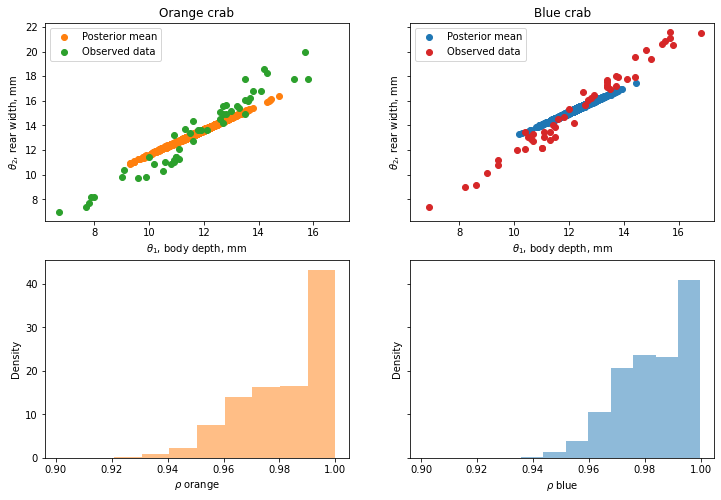

In [17]:
fig, ax = plt.subplots(2,2, figsize = (12,8), sharex = 'row', sharey = 'row')

ax[0,0].scatter(theta[0,:,0], theta[0,:,1], c='C1', label = 'Posterior mean')
ax[0,1].scatter(theta[1,:,0], theta[1,:,1], label = 'Posterior mean')

ax[0,0].scatter(y[0,:,0], y[0,:,1], c='C2', label = 'Observed data')
ax[0,1].scatter(y[1,:,0], y[1,:,1], c = 'C3', label = 'Observed data')

ax[0,0].legend()
ax[0,1].legend()

ax[1,0].hist(vec_rho[0], density = True, alpha = 0.5, color = 'C1')
ax[1,1].hist(vec_rho[1], density = True, alpha = 0.5)

ax[0,0].set(title = "Orange crab", xlabel = '$\\theta_1$, body depth, mm', ylabel = '$\\theta_2$, rear width, mm')
ax[0,1].set(title = "Blue crab", xlabel = '$\\theta_1$, body depth, mm', ylabel = '$\\theta_2$, rear width, mm')

ax[1,0].set(xlabel = '$\\rho$ orange', ylabel = 'Density')
ax[1,1].set(xlabel = '$\\rho$ blue', ylabel = 'Density')

# plt.savefig('/nfs/scistore12/gaspgrp/emaksimo/courses/CompBayesStat/plots/Ex5_2_Fig1.png')

In [10]:
np.sum(vec_rho[1]<vec_rho[0])/size

0.4986